In [3]:
import os
import matplotlib.pyplot as plt
import torch

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

smoke_test = ('CI' in os.environ)  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.3.0')
pyro.enable_validation(True)       # can help with debugging
pyro.set_rng_seed(0)
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
# note that this helper function does three different things:
# (i) plots the observed data;
# (ii) plots the predictions from the learned GP after conditioning on data;
# (iii) plots samples from the GP prior (with no conditioning on observed data)

def plot(plot_observed_data=False, plot_predictions=False, n_prior_samples=0,
         model=None, kernel=None, n_test=500):

    plt.figure(figsize=(12, 6))
    if plot_observed_data:
        plt.plot(X.numpy(), y.numpy(), 'kx')
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        plt.plot(Xtest.numpy(), mean.numpy(), 'r', lw=2)  # plot the mean
        plt.fill_between(Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
                         (mean - 2.0 * sd).numpy(),
                         (mean + 2.0 * sd).numpy(),
                         color='C0', alpha=0.3)
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = (model.noise if type(model) != gp.models.VariationalSparseGP
                 else model.likelihood.variance)
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(torch.zeros(n_test), covariance_matrix=cov)\
                      .sample(sample_shape=(n_prior_samples,))
        plt.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    plt.xlim(-0.5, 5.5)

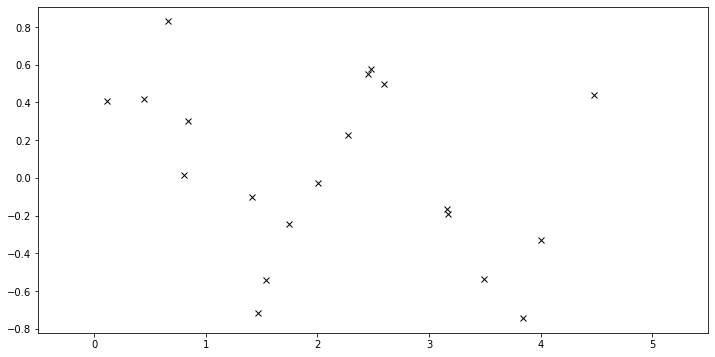

In [5]:
N = 20
X = dist.Uniform(0.0, 5.0).sample(sample_shape=(N,))
y = 0.5 * torch.sin(3*X) + dist.Normal(0.0, 0.2).sample(sample_shape=(N,))

plot(plot_observed_data=True)  # let's plot the observed data

In [6]:
kernel = gp.kernels.RBF(input_dim=1, variance=torch.tensor(5.),
                        lengthscale=torch.tensor(10.))
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1.))

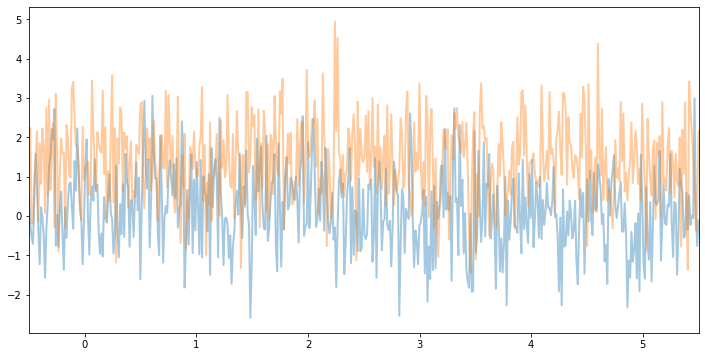

In [7]:
plot(model=gpr, kernel=kernel, n_prior_samples=2)

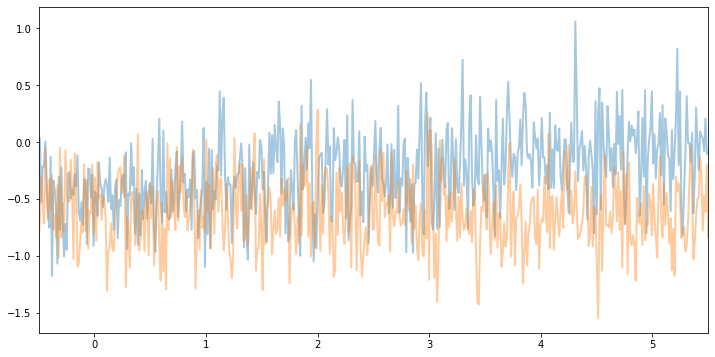

In [8]:
kernel2 = gp.kernels.RBF(input_dim=1, variance=torch.tensor(0.1),
                         lengthscale=torch.tensor(10.))
gpr2 = gp.models.GPRegression(X, y, kernel2, noise=torch.tensor(0.1))
plot(model=gpr2, kernel=kernel2, n_prior_samples=2)

In [9]:
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2500 if not smoke_test else 2
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

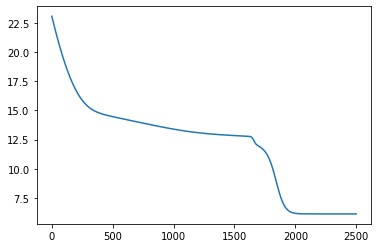

In [10]:
plt.plot(losses);

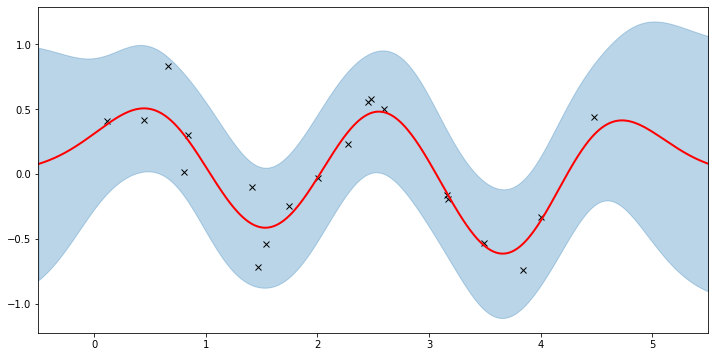

In [11]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True)

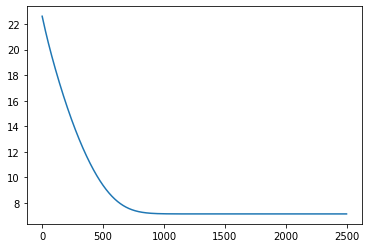

In [12]:
# Define the same model as before.
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1, variance=torch.tensor(5.),
                        lengthscale=torch.tensor(10.))
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1.))

# note that our priors have support on the positive reals
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2500 if not smoke_test else 2
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.plot(losses);

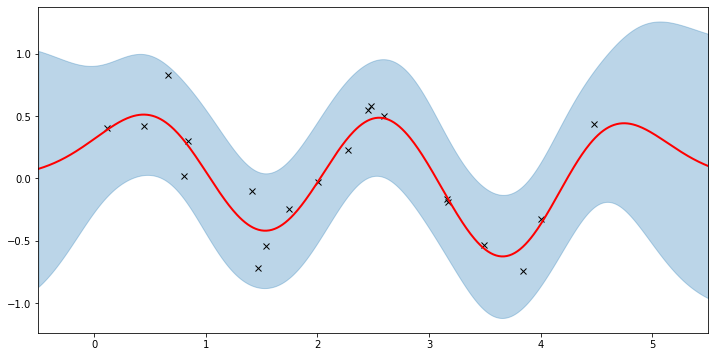

In [13]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True)